In [ ]:
# Instaling in Google Colab the libraries used for this assignemnt
# Don't run this cell if you are running the notebook locally

# !pip install pygame

In [1]:
# Importing the libraries

import os
import gymnasium as gym
from gym.wrappers.monitoring.video_recorder import VideoRecorder
import numpy as np
import matplotlib.pyplot as plt # Graphical library

import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu") # Configuring Pytorch

# Solution of Lab Assignment 3 :  
See pdf for instructions


## Part 1: Introduction to Gym environments

### Question 1: Creating the Cartpole environment and performing an episode

In [4]:
# Creating the environment and a recorder to save a video in the './random_episode' folder
# To save multiple videos, save each mp4 fle to a new directory

cwd = os.getcwd()
video_dir = os.path.join(cwd, 'random_episode')
if not os.path.isdir(video_dir):
    os.mkdir(video_dir)
video_file = os.path.join(video_dir, "random_episode.mp4")
env = gym.make('CartPole-v1', render_mode="rgb_array")

# Perform an episode in the environemnt with random actions
state = env.reset()

video_recorder = VideoRecorder(env, video_file, enabled=True)  #record a video of the episode
done = False
while not done:

    video_recorder.capture_frame()
    action = env.action_space.sample()  # sample a random possible action from the CartPole env
    next_state, reward, done, truncated, info = env.step(action)
    state = next_state

video_recorder.capture_frame()
video_recorder.close()
video_recorder.enabled = False

print(f"Video saved in folder {video_dir}")
env.close()

state, next_state, reward

Moviepy - Building video /Users/ruihongyu/Library/CloudStorage/OneDrive-ImperialCollegeLondon/Year_4/Reinforcement Learning/RL_CW_and_Lab/random_episode/random_episode.mp4.
Moviepy - Writing video /Users/ruihongyu/Library/CloudStorage/OneDrive-ImperialCollegeLondon/Year_4/Reinforcement Learning/RL_CW_and_Lab/random_episode/random_episode.mp4

Moviepy - Done !
Moviepy - video ready /Users/ruihongyu/Library/CloudStorage/OneDrive-ImperialCollegeLondon/Year_4/Reinforcement Learning/RL_CW_and_Lab/random_episode/random_episode.mp4
Video saved in folder /Users/ruihongyu/Library/CloudStorage/OneDrive-ImperialCollegeLondon/Year_4/Reinforcement Learning/RL_CW_and_Lab/random_episode


(array([ 0.10155994,  0.571885  , -0.20969762, -1.3703501 ], dtype=float32),
 array([ 0.10155994,  0.571885  , -0.20969762, -1.3703501 ], dtype=float32),
 1.0)

### Question 2: Implementing a simple hand-designed policy

In [30]:
# [Action required]
def simple_policy(state, p_random):
    """
    Simple hand-crafted policy to act in the Cartpole environment.
    Input:
        - state {tensor} - current state of the environment
        - p_random {float} - probability that the action is random
    Output: action {int} - action to perform in the environemnt
    """
    ####
    if state[3] > 0:
        ideal = 0
        non_ideal = 1
    else:
        ideal = 1
        non_ideal = 0
    a = np.random.choice([ideal, non_ideal], 1, p = (p_random, 1- p_random))
    ####

    return a[0]



In [31]:
# Rate of random action sampling
p_random = 0.2

cwd = os.getcwd()
video_dir = os.path.join(cwd, 'random_episode')
if not os.path.isdir(video_dir):
    os.mkdir(video_dir)
video_file = os.path.join(video_dir, "simple_policy.mp4")
env = gym.make('CartPole-v1', render_mode="rgb_array")

video_recorder = VideoRecorder(env, video_file, enabled=True)  #record a video of the episode

# Performing an episode in the environemnt with simple policy
state = env.reset()[0]
print(type(state))
print(state)
done = False
while not done:
    video_recorder.capture_frame()
    action = simple_policy(state, p_random)
    print(action)
    next_state, reward, done, info, *rest = env.step(action)
    state = next_state
    print(state)

video_recorder.capture_frame()
video_recorder.close()
video_recorder.enabled = False

print(f"Video saved in folder {video_dir}")

env.close()

<class 'numpy.ndarray'>
[0.00792761 0.03959452 0.04347874 0.02721838]
1
[ 0.0087195   0.23406686  0.04402311 -0.25143573]
0
[0.01340083 0.03834482 0.03899439 0.05480151]
1
[ 0.01416773  0.23288658  0.04009042 -0.22532786]
0
[0.01882546 0.03721527 0.03558386 0.0797267 ]
0
[ 0.01956977 -0.15839824  0.0371784   0.38342065]
1
[0.0164018  0.03617667 0.04484681 0.10268791]
1
[ 0.01712534  0.23062818  0.04690057 -0.17551555]
0
[0.0217379  0.03486749 0.04339026 0.13158631]
0
[ 0.02243525 -0.16084829  0.04602199  0.4376364 ]
1
[0.01921828 0.03359306 0.05477472 0.15980889]
1
[ 0.01989015  0.22788978  0.05797089 -0.11510339]
0
[0.02444794 0.03198717 0.05566882 0.1952908 ]
1
[ 0.02508768  0.22627045  0.05957464 -0.0793245 ]
0
[0.02961309 0.03034733 0.05798815 0.23154342]
1
[ 0.03022004  0.2245948   0.06261902 -0.04229907]
0
[0.03471194 0.0286334  0.06177304 0.26946488]
1
[ 0.0352846   0.2228219   0.06716233 -0.00311259]
0
[0.03974104 0.02680425 0.06710009 0.30998188]
1
[0.04027713 0.22090921 0.073

Moviepy - Done !
Moviepy - video ready /Users/ruihongyu/Library/CloudStorage/OneDrive-ImperialCollegeLondon/Year_4/Reinforcement Learning/RL_CW_and_Lab/random_episode/simple_policy.mp4
Video saved in folder /Users/ruihongyu/Library/CloudStorage/OneDrive-ImperialCollegeLondon/Year_4/Reinforcement Learning/RL_CW_and_Lab/random_episode


## Part 2: Introduction to PyTorch

### Helper Functions

### Question 3: Understanding the MLP class

In [34]:
# Multi Layer perceptron class

class MLP(nn.Module):

    def __init__(self, input_size, output_size, num_hidden, hidden_size):
        """
        Initialise the network.
        Input:
            - input_size {int} - size of input to the network
            - output_size {int} - size of output to the network
            - num_hidden {int} - number of hidden layers
            - hidden_size {int} - size of each hidden layer
        """
        super(MLP, self).__init__()
        self.input_layer = nn.Linear(input_size, hidden_size) # First tranformation from the network input to the input of first hidden layer
        self.hidden_layers = nn.ModuleList([nn.Linear(hidden_size, hidden_size) for _ in range(num_hidden-1)]) # All the hidden transformation
        self.output_layer = nn.Linear(hidden_size, output_size) # Last tranformation from the last hidden layer output to the network output

    def forward(self, x):
        """
        Get the output of the MLP.
        Input: x {tensor} - one element or a batch of element
        Ouput: y {tensor} - corresponding output
        """
        x.to(device)
        x = self.input_layer(x) # Passing through the input layer
        x = F.relu(x) # Applying Relu activation
        for layer in self.hidden_layers:
          x = layer(x) # Passing through each hidden layer
          x = F.relu(x) # Applying Relu activation
        x = self.output_layer(x) # Passing through the output layer
        return x

In [35]:
# Initialise an MLP instance
input_size = 10
output_size = 10
num_hidden = 3
hidden_size = 15

model = MLP(input_size, output_size, num_hidden, hidden_size)

# Creating some false input
x = torch.rand(10) # Random tensor
print("The input is:\n", x)

# Passing it through the network
y = model.forward(x)
print("\nThe correpsonding output is:\n", y)
print("\nThe network has not been trained yet so this output is random.")

The input is:
 tensor([0.0273, 0.6299, 0.5012, 0.0252, 0.9214, 0.1750, 0.1809, 0.5552, 0.0520,
        0.0226])

The correpsonding output is:
 tensor([-0.1241,  0.0649, -0.1152, -0.2165, -0.2367, -0.3072, -0.1428, -0.0642,
        -0.2074, -0.2178], grad_fn=<ViewBackward0>)

The network has not been trained yet so this output is random.


### Question 4: Collecting data to train the state-predictor model

In [40]:
def batch_data(state_list, action_list, next_state_list, batch_size, num_batches):
  """
  Reshape the data to match the model requirements.
  Input:
    - state_list {list of torch.tensor} - list of state encountered during all num_episode episodes
    - action_list {list of torch.tensor} - list of action applied during all num_episode episodes
    - next_state_list {list of torch.tensor} - list of next state each action lead to during all num_episode episodes
    - batch_size {int} - number of steps in a batch
    - num_batches {int} - total number of batches
  Ouput:
    - batched_state_action {torch.tensor} - input of the model of size (batch_size, 5)
    - batched_next_state {torch.tensor} - target output of the model of size (batch_size, 4)
  """
  # Reshape and concatenate the state and action (input of the network)
  state_action_list = [torch.cat((torch.tensor(state_list[i]).float().unsqueeze(0), torch.tensor(action_list[i]).unsqueeze(0).unsqueeze(0)), dim=-1) for i in range(len(state_list))]
  state_action = torch.cat(state_action_list)

  # Reshape the next state
  next_state = torch.cat([torch.tensor(next_state_list[i]).float().unsqueeze(0) for i in range(len(next_state_list))])

  # Rearrange the data into batches
  batched_state_action = [state_action[batch*batch_size:(batch+1)*batch_size] for batch in range(num_batches)]
  batched_next_state = [next_state[batch*batch_size:(batch+1)*batch_size] for batch in range(num_batches)]

  return batched_state_action, batched_next_state

In [81]:
# [Action required]
def collect_data(num_episodes, p_random):
  """
  Collect the data to train the predictor model.
  Input:
    - num_episode {int} - number of episodes to collect
    - p_random {float} - probability used for the simple policy
  Output:
    - state_list {list of torch.tensor} - list of state encountered during all num_episode episodes
    - action_list {list of torch.tensor} - list of action applied during all num_episode episodes
    - next_state_list {list of torch.tensor} - list of next state each action lead to during all num_episode episodes
  """

  # Containers for the data
  state_list = [] # List of current states
  action_list = [] # List of current actions
  next_state_list = [] # List of next step states

  # Creating the environment
  env = gym.make('CartPole-v1')

  ####
  # Add your code here
  # This is an example on how to fill state_list, action_list and next_state_list
  # You would need to update it to collect enough data
  for i in range(num_episodes-1):
    state = env.reset()[0]

    action = simple_policy(state, p_random)
    next_state, reward, done, _, *rest = env.step(action)

    state_list.append(state)
    action_list.append(action)
    next_state_list.append(next_state)

    while not done:
      state = next_state
      action = simple_policy(state, p_random)
      next_state, reward, done, _, *rest = env.step(action)
      state_list.append(state)
      action_list.append(action)
      next_state_list.append(next_state)

  # Closing the environment
  env.close()

  return state_list, action_list, next_state_list

In [82]:
# Define parameters for the model
num_episodes = 5000 # Total number of episodes collected in our dataset
batch_size = 128 # Size of the batch to train the DNN
p_random = 0.2 # Parameter of the simple_policy

# Collect the data
state_list, action_list, next_state_list = collect_data(num_episodes, p_random)
num_batches = int(len(state_list)/batch_size)

# Reshape them to match the model input/output
batched_state_action, batched_next_state = batch_data(state_list, action_list, next_state_list, batch_size, num_batches)

In [48]:
batched_state_action[0], batched_next_state[0]

(tensor([[ 2.6857e-03, -2.5521e-02, -2.3896e-02, -3.0729e-03,  0.0000e+00],
         [ 2.1753e-03, -2.2029e-01, -2.3957e-02,  2.8198e-01,  1.0000e+00],
         [-2.2306e-03, -2.4837e-02, -1.8318e-02, -1.8166e-02,  0.0000e+00],
         [-2.7273e-03, -2.1969e-01, -1.8681e-02,  2.6868e-01,  1.0000e+00],
         [-7.1211e-03, -2.4308e-02, -1.3307e-02, -2.9834e-02,  1.0000e+00],
         [-7.6073e-03,  1.7100e-01, -1.3904e-02, -3.2669e-01,  1.0000e+00],
         [-4.1873e-03,  3.6632e-01, -2.0438e-02, -6.2372e-01,  0.0000e+00],
         [ 3.1391e-03,  1.7149e-01, -3.2912e-02, -3.3754e-01,  0.0000e+00],
         [ 6.5689e-03, -2.3150e-02, -3.9663e-02, -5.5419e-02,  0.0000e+00],
         [ 6.1059e-03, -2.1768e-01, -4.0771e-02,  2.2449e-01,  1.0000e+00],
         [ 1.7523e-03, -2.2001e-02, -3.6282e-02, -8.0769e-02,  0.0000e+00],
         [ 1.3122e-03, -2.1658e-01, -3.7897e-02,  2.0025e-01,  1.0000e+00],
         [-3.0195e-03, -2.0942e-02, -3.3892e-02, -1.0414e-01,  0.0000e+00],
         [-3

### Question 5: Training a state predictor model

In [43]:
def MSE_loss(prediction, target):
  """
  MSE loss function.
  Input:
    - prediction {torch.tensor} - target
    - target {torch.tensor} - model prediction
  Output: loss {float} - MSE error between the prediction and the target
  """
  return ((prediction - target)**2).sum(dim=-1).mean()

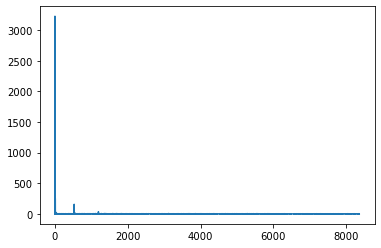

In [72]:
# Creating the environment
env = gym.make('CartPole-v1')

# Defining the parameters
state_dim = 4
action_dim = 1

input_size = state_dim + action_dim
output_size = state_dim
num_hidden = 2
hidden_size = 50

# Creating the predictor model
state_predictor = MLP(input_size, output_size, num_hidden, hidden_size)

# Creating the optmizer
optimiser = optim.Adam(state_predictor.parameters(), lr = 0.4)

# [Action required]
# Training loop
num_epochs = 2
losses = [] # Contain all successive loss function values

####
for i in range(num_epochs):
    for j in range(num_batches):

        optimiser = optim.Adam(state_predictor.parameters(), lr = (0.4 - 0.4* (i * num_batches + j) / ((num_batches+1) * (num_epochs+1)) ) )
        # forward
        y_pred = state_predictor(batched_state_action[j])

        loss = MSE_loss(prediction= y_pred, target= batched_next_state[j])

        losses.append(loss)
        
        optimiser.zero_grad()

        loss.backward()

        optimiser.step()
  

####

# Closing the environment
env.close()

# Plot the loss across training
plt.plot([t.item() for t in losses])

([<matplotlib.lines.Line2D at 0x7fcaf8fd4580>], 4178)

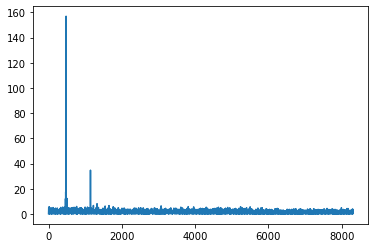

In [78]:
import math
plt.plot([t.item() for t in losses][50:-1]), num_batches

In [106]:
# Graphical class: this class modifies the original Gym class to be able to visualise your prediction
# You DO NOT need to understand it to work on this lab assessment

from gym.envs.classic_control.cartpole import CartPoleEnv

class ShowCartPolePredictions(CartPoleEnv):
    def __init__(self):
        super(ShowCartPolePredictions, self).__init__()
        # 确保定义了 action_space 和 observation_space
        self.action_space = gym.spaces.Discrete(2)  # 假设动作空间是离散的，且有2个可能的动作
        self.observation_space = gym.spaces.Box(
            low=np.array([-2.4, -3.0, -0.20943951, -3.0]),
            high=np.array([2.4, 3.0, 0.20943951, 3.0]),
            dtype=np.float32
        )

    def step(self, state):
        """
        Step takes the next state as input instead of action.
        """
        self.state = state
        x, x_dot, theta, theta_dot = state

        done = bool(
            x < -self.x_threshold
            or x > self.x_threshold
            or theta < -self.theta_threshold_radians
            or theta > self.theta_threshold_radians
                )

        reward = 1.

        return np.array(self.state, dtype=np.float32), reward, done, {}

nb_path = os.path.join(os.getcwd(), 'tutorial_3_solution.ipynb')
gym.envs.register(
     id='ShowPredictionsCartPole',
     entry_point=ShowCartPolePredictions,
     max_episode_steps=500,
)

<class 'type'>


In [107]:
# Displaying the learned model dynamics in the CartPole environment

# simulated_env allows us to visualise the learned model dynamics
# by calling simulated_env.set_next_state(next_state) we set the learned
# next_state and we can visualise what the learned dynamics looks like
# video saved in the 'learned_dynamics' folder

# setting up the visualisation

cwd = os.getcwd()
video_dir = os.path.join(cwd, 'learned_dynamics')
if not os.path.isdir(video_dir):
    os.mkdir(video_dir)
video_file = os.path.join(video_dir, "learned_dynamics.mp4")

simulated_env = gym.make('ShowPredictionsCartPole')
print(type(simulated_env))
#TimeLimit)(ShowCartPolePredictions(), max_episode_steps=500)
video_recorder = VideoRecorder(simulated_env, video_file, enabled=True)

state = simulated_env.reset()

#Performing the episode
state = simulated_env.reset()
done = False
state = torch.tensor(simulated_env.state).float()

while not done:

    # Store the current state of the CartPole for the video
    video_recorder.capture_frame()

    # Predict the state with the model
    action = torch.tensor([simple_policy(state, p_random)])
    state_action = torch.cat((state, action))
    with torch.no_grad():
        predicted_state = state_predictor(state_action)
        predicted_state = list([float(s) for s in predicted_state.squeeze()])

    # Apply it in the environment
    state, reward, done, info, *rest = simulated_env.step(predicted_state)
    state = torch.tensor(simulated_env.state).float()

video_recorder.capture_frame()
video_recorder.close()
video_recorder.enabled = False

simulated_env.close()

<class 'gymnasium.wrappers.time_limit.TimeLimit'>


/Users/ruihongyu/opt/anaconda3/lib/python3.8/site-packages/gym/wrappers/monitoring/video_recorder.py:59: UserWarning: WARN: Disabling video recorder because environment <TimeLimit<OrderEnforcing<PassiveEnvChecker<ShowCartPolePredictions<ShowPredictionsCartPole>>>>> was not initialized with any compatible video mode between `rgb_array` and `rgb_array_list`
  logger.warn(
/Users/ruihongyu/opt/anaconda3/lib/python3.8/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.state to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.state` for environment variables or `env.get_wrapper_attr('state')` that will search the reminding wrappers.
  logger.warn(
/Users/ruihongyu/opt/anaconda3/lib/python3.8/site-packages/gym/envs/classic_control/cartpole.py:211: UserWarning: WARN: You are calling render method without specifying any render mode. You can specify the render_mode at initialization, e.g. gym("ShowPredictionsCar

ValueError: not enough values to unpack (expected 5, got 4)

### Question 6: Trying multiple loss functions

In [ ]:
# Alternative loss function

def L1_loss(prediction, target):
  """
  L1 loss function.
  Input:
    - prediction {torch.tensor} - target
    - target {torch.tensor} - model prediction
  Output: loss {float} - L1 error between the prediction and the target
  """
  return (abs(prediction - target)).sum()

In [ ]:
## Torch MSE loss function
torch_MSE_loss = nn.MSELoss()

# You can call it the same way you would do with our hand design loss:
inputs = batched_state_action[0] # Input of the model for this batch
targets = batched_next_state[0] # Target output of the model for this batch
loss = torch_MSE_loss(state_predictor(inputs), targets)
print(loss)

## Torch L1 loss function
torch_L1_loss = nn.L1Loss()

# You can call it the same way you would do with our hand design loss:
inputs = batched_state_action[0] # Input of the model for this batch
targets = batched_next_state[0] # Target output of the model for this batch
loss = torch_L1_loss(state_predictor(inputs), targets)
print(loss)

## Torch Huber loss function
torch_Huber_loss = nn.HuberLoss()

# You can call it the same way you would do with our hand design loss:
inputs = batched_state_action[0] # Input of the model for this batch
targets = batched_next_state[0] # Target output of the model for this batch
loss = torch_Huber_loss(state_predictor(inputs), targets)
print(loss)

IndexError: ignored